## Sklearn Modeling Workflow

An example of using Sklearn to perform cross validation and create models for a binary outcome (survived titanic). Hyperparameters are trained with random search. 

Lift curves are generated for analyzing the results.

In [1]:
import logging
import pandas as pd
import joblib
import numpy as np
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import classification_report
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,cross_val_score,RandomizedSearchCV
from sklearn.metrics import accuracy_score, brier_score_loss
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint as sp_randint # use this random number generator for randomized grid search
from scipy.stats import uniform as sp_uniform

# Warning
import warnings
warnings.filterwarnings("ignore")

# Return a dataframe with a count column for specified group by variable(s)
def count_groupby(df,groupbyvars):
    return(df.groupby(groupbyvars).size().reset_index().rename(columns={0: 'n'}))

pd.set_option('display.max_columns', 500)

Load data

In [2]:
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [3]:
titanic.shape

(891, 15)

In [4]:
titanic.dtypes

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object

In [5]:
titanic.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


In [6]:
# Test/Train split
X_train, X_test, y_train, y_test = train_test_split(titanic[['adult_male','fare','alone']], 
                                                    titanic['survived'].values, 
                                                    test_size=0.20, random_state=42)

## Run model pipelines

In [7]:
MySeed = 42
# Grid Searches for each model:
jobs = -1
score_fn = 'brier_score_loss'
Mycv = StratifiedKFold(n_splits=5, shuffle=True, random_state=MySeed)

pipe_nn = Pipeline([
    ('scaler', MinMaxScaler()),
                    ('clf', MLPClassifier(random_state=MySeed,solver='adam',max_iter=300))
                   ])

pipe_rf = Pipeline([
    ('scaler', RobustScaler()),
                    ('clf', RandomForestClassifier(random_state=MySeed,n_estimators=100))
                   ])


# specify parameters and distributions to sample from
rf_param_dist = {
              "clf__max_depth": sp_randint(1, 10),
        #      "clf__max_features": sp_randint(1, 11),
              "clf__min_samples_split": sp_randint(2, 20),
              "clf__criterion": ["gini", "entropy"],
              'clf__max_features' : ['sqrt','log2']
                }

nn_param_dist = {'clf__hidden_layer_sizes': [(1,),(3,),(5,)],
       #     'clf__learning_rate': ['constant'],
        #    'clf__solver' : ['adam'],
        #    'clf__activation': ['relu'],
            'clf__alpha' : sp_uniform(0.0,1)
                }

# Randomized Search objects
gs_rf = RandomizedSearchCV(pipe_rf,
            rf_param_dist,
            scoring=score_fn,
            random_state=MySeed,
            cv=Mycv,
            n_iter=30,
            n_jobs=jobs)

gs_nn = RandomizedSearchCV(pipe_nn,
            nn_param_dist,
            scoring=score_fn,
            random_state=MySeed,
            cv=Mycv,
            n_iter=30,
            n_jobs=jobs)


# Dictionary of 'model name' : modelPipeline
grids = {
     #    'Logistic Regression' : gs_lr, 
    #  'Logistic Regression w PCA' : gs_lr_pca,
         'Random Forest' : gs_rf,
     #    'Random Forest w PCA' : gs_rf_pca,
         'Neural Network': gs_nn
        }

best_models = dict()
cv_results = dict()
for model_name, gs in grids.items():
    print('\nEstimator: %s' % model_name)
    start = time.time()
    
    # Fit grid search:
    gs.fit(X_train, y_train)
    
    # Best parameters:
    print('Best parameters: %s' % gs.best_params_)
    
    # Best training data accuracy:
    # Average of all cross validation score ("folds") of the best estimator
    # for a single combination of the parameters you specify in the tuned_params
    print('Kfold CV Mean Brier Score Loss: %.3f' % abs(gs.best_score_))
    
    print('Brier Score on Training Data: %.3f' % brier_score_loss(y_train,gs.predict_proba(X_train)[:,1]))
    best_models[model_name] = gs.best_estimator_
    cv_results[model_name] = gs.cv_results_

    # Predict on test data with best parameters:
    y_pred = gs.predict(X_test)
    y_prob = gs.predict_proba(X_test)[:,1] # extract probabilities for y=1 (match)
    
    # Test data accuracy of model with best parameters:
    print('Test data accuracy: %.3f ' % accuracy_score(y_test, y_pred))
    print('Test brier score: %.3f' % brier_score_loss(y_test, y_prob))
    # Precision, Recall and F1:
    print('Precision, recall & f1-score:\n',classification_report(y_test, y_pred))
    print('runtime: %s'%(time.time()-start))


Estimator: Random Forest
Best parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 12}
Kfold CV Mean Brier Score Loss: 0.143
Brier Score on Training Data: 0.097
Test data accuracy: 0.793 
Test brier score: 0.150
Precision, recall & f1-score:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       105
           1       0.77      0.72      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

runtime: 4.920530796051025

Estimator: Neural Network
Best parameters: {'clf__alpha': 0.020584494295802447, 'clf__hidden_layer_sizes': (3,)}
Kfold CV Mean Brier Score Loss: 0.158
Brier Score on Training Data: 0.157
Test data accuracy: 0.788 
Test brier score: 0.161
Precision, recall & f1-score:
               precision    recall  f1-score   support

           0

In [11]:
## Save Models

In [12]:
import pickle
pickle.dump(best_models['Neural Network'], open('NN.pickle', 'wb'))
pickle.dump(best_models['Random Forest'], open('RF.pickle', 'wb'))

In [8]:
imp_features = pd.DataFrame()
imp_features['Feature'] = X_train.columns.values.tolist()
imp_features['Importance'] = best_models['Random Forest'].named_steps['clf'].feature_importances_.tolist()
imp_features.sort_values('Importance',ascending=False,inplace=True)

In [9]:
imp_features

,Feature,Importance
1,fare,0.592487
0,adult_male,0.379428
2,alone,0.028086


In [10]:
def cv_results_summary(CVResults,model_name):
    CompareCVResults = pd.DataFrame()
    CompareCVResults['Score Rank'] = CVResults['rank_test_score'].tolist()
    CompareCVResults['Model Name'] = model_name
 #   CompareCVResults['Hidden Layer'] = CVResults['param_clf__hidden_layer_sizes'].tolist()
    CompareCVResults['params'] = CVResults['params']
    CompareCVResults['Mean Test Score'] = [ abs(score) for score in CVResults['mean_test_score'].tolist() ]
 #   CompareCVResults['L2'] = CVResults['param_clf__alpha']
    CompareCVResults['Mean Fit Time'] = CVResults['mean_fit_time']
    CompareCVResults.sort_values('Mean Test Score',ascending=True,inplace=True)
    return(CompareCVResults)

all_cv_results = pd.concat([cv_results_summary(cv_results[model_name],model_name) for model_name in cv_results]).\
    sort_values('Mean Test Score')

In [11]:
pd.set_option('display.max_colwidth', 200)
all_cv_results.sample(5)

,Score Rank,Model Name,params,Mean Test Score,Mean Fit Time
24,27,Random Forest,"{'clf__criterion': 'gini', 'clf__max_depth': 1, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 6}",0.182798,0.122743
4,14,Random Forest,"{'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 3}",0.144903,0.140536
15,30,Neural Network,"{'clf__alpha': 0.9832308858067882, 'clf__hidden_layer_sizes': (1,)}",0.213813,0.409822
23,27,Random Forest,"{'clf__criterion': 'gini', 'clf__max_depth': 1, 'clf__max_features': 'log2', 'clf__min_samples_split': 4}",0.182798,0.124231
25,9,Random Forest,"{'clf__criterion': 'entropy', 'clf__max_depth': 7, 'clf__max_features': 'log2', 'clf__min_samples_split': 10}",0.143928,0.147869


In [12]:
# Calculate lift and associated metrics
def calculate_lift(model,model_name):
    lift_curve_pd = pd.DataFrame({
    'prob' : model.predict_proba(X_test)[:,1],
    'pred' : model.predict(X_test),
    'truth' : y_test
    }).sort_values('prob',ascending=False).reset_index(drop=True)
    lift_curve_pd['model'] = model_name
    lift_curve_pd['cum_truth'] = lift_curve_pd['truth'].cumsum()
    lift_curve_pd['percentile'] = (lift_curve_pd.index+1)/len(lift_curve_pd)
    lift_curve_pd['capture_percent'] = lift_curve_pd['cum_truth'] / lift_curve_pd['cum_truth'].max()
    lift_curve_pd['lift']  = lift_curve_pd['cum_truth'] / \
       (lift_curve_pd['percentile']*lift_curve_pd['cum_truth'].max())
    return(lift_curve_pd)

all_lifts = pd.concat([calculate_lift(best_models[model_name],model_name) for model_name in grids])

In [13]:
# Extract Lift at Specific Junctions
def summarize_lifts(df):
    # Which percentiles we want to return
    x_range = np.arange(0.1,0.51,0.1)
    
    # Interpolate to find the row that is closest to each percentile
    q = df[["model","percentile"]].groupby('model').quantile(x_range, interpolation = 'nearest').reset_index()
    df_summ = df.merge(q,on=['model','percentile'],how='inner').\
       pivot(index='level_1',columns='model',values='lift')
    df_summ.columns.name =''
    df_summ.reset_index(inplace=True)
    df_summ.rename(columns={'level_1':'Percentile'},inplace=True)
    return(df_summ)

all_lifts_summ = summarize_lifts(all_lifts)

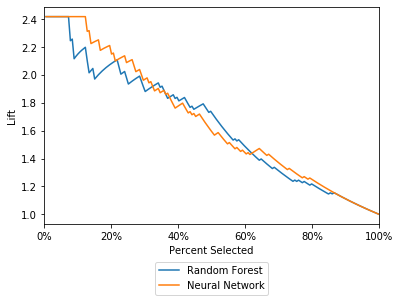

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
ax =sns.lineplot(data=all_lifts,x="percentile",y="lift",hue='model')
# delete legend title and position legend outside graph
Null, labels = ax.get_legend_handles_labels() 
ax.legend(labels=labels[1:],loc=9, bbox_to_anchor=(0.5, -0.15))
ax.xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
plt.ylabel('Lift')
plt.xlabel('Percent Selected')
plt.xlim([0,1])
plt.ylim()
plt.show()

In [16]:
best_models['Neural Network'].get_params().pop('steps')

[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
 ('clf',
  MLPClassifier(activation='relu', alpha=0.020584494295802447, batch_size='auto',
                beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
                hidden_layer_sizes=(3,), learning_rate='constant',
                learning_rate_init=0.001, max_iter=300, momentum=0.9,
                n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
                random_state=42, shuffle=True, solver='adam', tol=0.0001,
                validation_fraction=0.1, verbose=False, warm_start=False))]